# AdaBoost 二分类代码演示

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np

## 样例数据

In [3]:
x = range(0,10)
y = [1,1,1,-1,-1,-1,1,1,1,-1]

## 展示样例数据

In [4]:
# 仅展示出来便于观察，无其他用途
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,1
2,2,1
3,3,-1
4,4,-1
5,5,-1
6,6,1
7,7,1
8,8,1
9,9,-1


## 样例数据说明

x为0~9样本数据，y为对应x的标签，y取值范围为{-1,1}

## 代码实现

### 逻辑封装

In [5]:
def hypothesis(threshold, lt_value, gt_value):
    """假设函数工厂，用于生成假设函数"""
    return lambda X: np.array([lt_value if x < threshold else gt_value for x in X])

class WeakClassifier(object):
    """弱分类器类，实现了单个分类器的参数、权重计算"""
    
    def __init__(self, name, hypothesis):
        self.__name = name
        self.__hypothesis = hypothesis
        self.__weight = 1.0
        self.__data_size = 0
        self.__error_rate = None
        self.__weight_error_rate = None
        self.__example_weight = None
    
    def predict(self, X):
        return self.__hypothesis(X)
        
    def fit(self, X_train, Y_train):
        self.__X_train = X_train
        self.__Y_train = Y_train
        self.__Y_pred = self.predict(X_train)
        self.__error_x = self.__X_train[np.where(self.__Y_train != self.__Y_pred)]
        self.__data_size = self.__Y_train.size
        self.__error_rate = self.__calc_error_rate()
        self.__alpha = self.__calc_alpha()
        return self
        
    def __I(self, y, y_pred):
        return 1 if y != y_pred else 0
        
    def __calc_error_rate(self):
        return ((self.__Y_train != self.__Y_pred) * self.__example_weight).sum()
    
    def __calc_alpha(self):
        return 0.5 * np.log((1 - self.__error_rate) / self.__error_rate)
    
    def new_example_weight(self):
        weights = self.__example_weight * np.exp(-1 * self.__alpha * self.__Y_train * self.__Y_pred)
        return weights / weights.sum()
        
    @property  
    def name(self):
        """获取分类器名称"""
        return self.__name
    
    @property    
    def error_rate(self):
        """获取错误率"""
        return self.__error_rate
    
    @property 
    def alpha(self):
        """获取alpha参数"""
        return self.__alpha
    
    @property
    def example_weight(self):
        """获取样本权重"""
        return self.__example_weight;
    
    @example_weight.setter
    def example_weight(self, example_weight):
        """设置样本权重"""
        self.__example_weight = example_weight

    
class AdaBoost:
    """AdaBoost主逻辑实现"""
    
    def __init__(self, classifiers):
        self.__classifiers = classifiers
        self.__times = 0
        self.__error_rate = 1.0
        self.__statistics = None
        
    def __update_example_weight(self, example_weight):
        for cf in self.__classifiers: 
            cf.example_weight = example_weight
        
    def __choose_best_classifier(self, X_train, Y_train):
        index = np.argmin([cf.error_rate for cf in map(lambda cf: cf.fit(X_train, Y_train), self.__classifiers)])
        return self.__classifiers[index]
    
    def fit(self, X_train, Y_train, max_times=10000, max_error_rate=0.1, log=False, record_statistics=False):
        _X_train = np.array(X_train)
        _Y_train = np.array(Y_train)
        assert _X_train.size == _Y_train.size, "the size of X_train must equal the size of Y_train"
        
        times = 0
        #初始化权重
        example_weight = np.full(_X_train.size, 1.0 / _X_train.size)
        
        self.__statistics = {'times':[], 'error_rate':[], 'best_classifier':[], 'example_weight':[example_weight]}
        
        while self.__times < max_times and self.__error_rate > max_error_rate: 
            #设置样本权重
            self.__update_example_weight(example_weight)
            #选择最优的弱分类器
            best_classifier = self.__choose_best_classifier(_X_train, _Y_train)
            self.__error_rate = best_classifier.error_rate
            #获取最新样本权重
            example_weight = best_classifier.new_example_weight()
            
            self.__times += 1
            
            #更新统计数据
            if(record_statistics):
                self.__statistics['times'].append(self.__times)
                self.__statistics['error_rate'].append(self.__error_rate)
                self.__statistics['best_classifier'].append(best_classifier.name)
                self.__statistics['example_weight'].append(example_weight)
            
            #打印日志
            if(log):
                print("============ TIMES {} ============".format(self.__times))
                print("best classifier: {}".format(best_classifier.name))
                print("min error rate: {}".format(best_classifier.error_rate))
                print(example_weight)
                print("---------- ERROR RATE ----------")
                for cf in self.__classifiers:
                    print("{} {}".format(cf.name, cf.error_rate))
                    
    
    def predict(self, X, Y):
        """do predict"""
        return np.sign(np.array(map(lambda cf: cf.alpha * cf.predict(X, Y)) , self.__classifiers).sum())
    
    @property    
    def error_rate(self):
        return self.__error_rate
    
    @property
    def times(self):
        return self.__times
    
    @property
    def statistics(self):
        return self.__statistics

### 训练

In [6]:
G1 = WeakClassifier('G1', hypothesis(2.5, 1, -1))
G2 = WeakClassifier('G2', hypothesis(5.5, -1, 1))
G3 = WeakClassifier('G3', hypothesis(8.5, 1, -1))

weak_classifiers = [G1, G2, G3]
adaboost = AdaBoost(weak_classifiers)
adaboost.fit(x, y, max_times=50, log=False, record_statistics=True)
print("============ SUMMARY ============")
print("RUN TIMES:{}".format(adaboost.times))
print("ERROR RATE:{}".format(adaboost.error_rate))

============ SUMMARY ============
RUN TIMES:50
ERROR RATE:0.190983005625


## 运行数据可视化

### 权重数据 

In [7]:
df=pd.DataFrame(adaboost.statistics['example_weight'])
display(df)

,0,1,2,3,4,5,6,7,8,9
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.166667,0.166667,0.166667,0.071429
2,0.045455,0.045455,0.045455,0.166667,0.166667,0.166667,0.106061,0.106061,0.106061,0.045455
3,0.125000,0.125000,0.125000,0.101852,0.101852,0.101852,0.064815,0.064815,0.064815,0.125000
4,0.077586,0.077586,0.077586,0.063218,0.063218,0.063218,0.166667,0.166667,0.166667,0.077586
5,0.047872,0.047872,0.047872,0.166667,0.166667,0.166667,0.102837,0.102837,0.102837,0.047872
6,0.125000,0.125000,0.125000,0.103070,0.103070,0.103070,0.063596,0.063596,0.063596,0.125000
7,0.077236,0.077236,0.077236,0.063686,0.063686,0.063686,0.166667,0.166667,0.166667,0.077236
8,0.047739,0.047739,0.047739,0.166667,0.166667,0.166667,0.103015,0.103015,0.103015,0.047739
9,0.125000,0.125000,0.125000,0.103002,0.103002,0.103002,0.063665,0.063665,0.063665,0.125000


### 权重随训练次数变化趋势

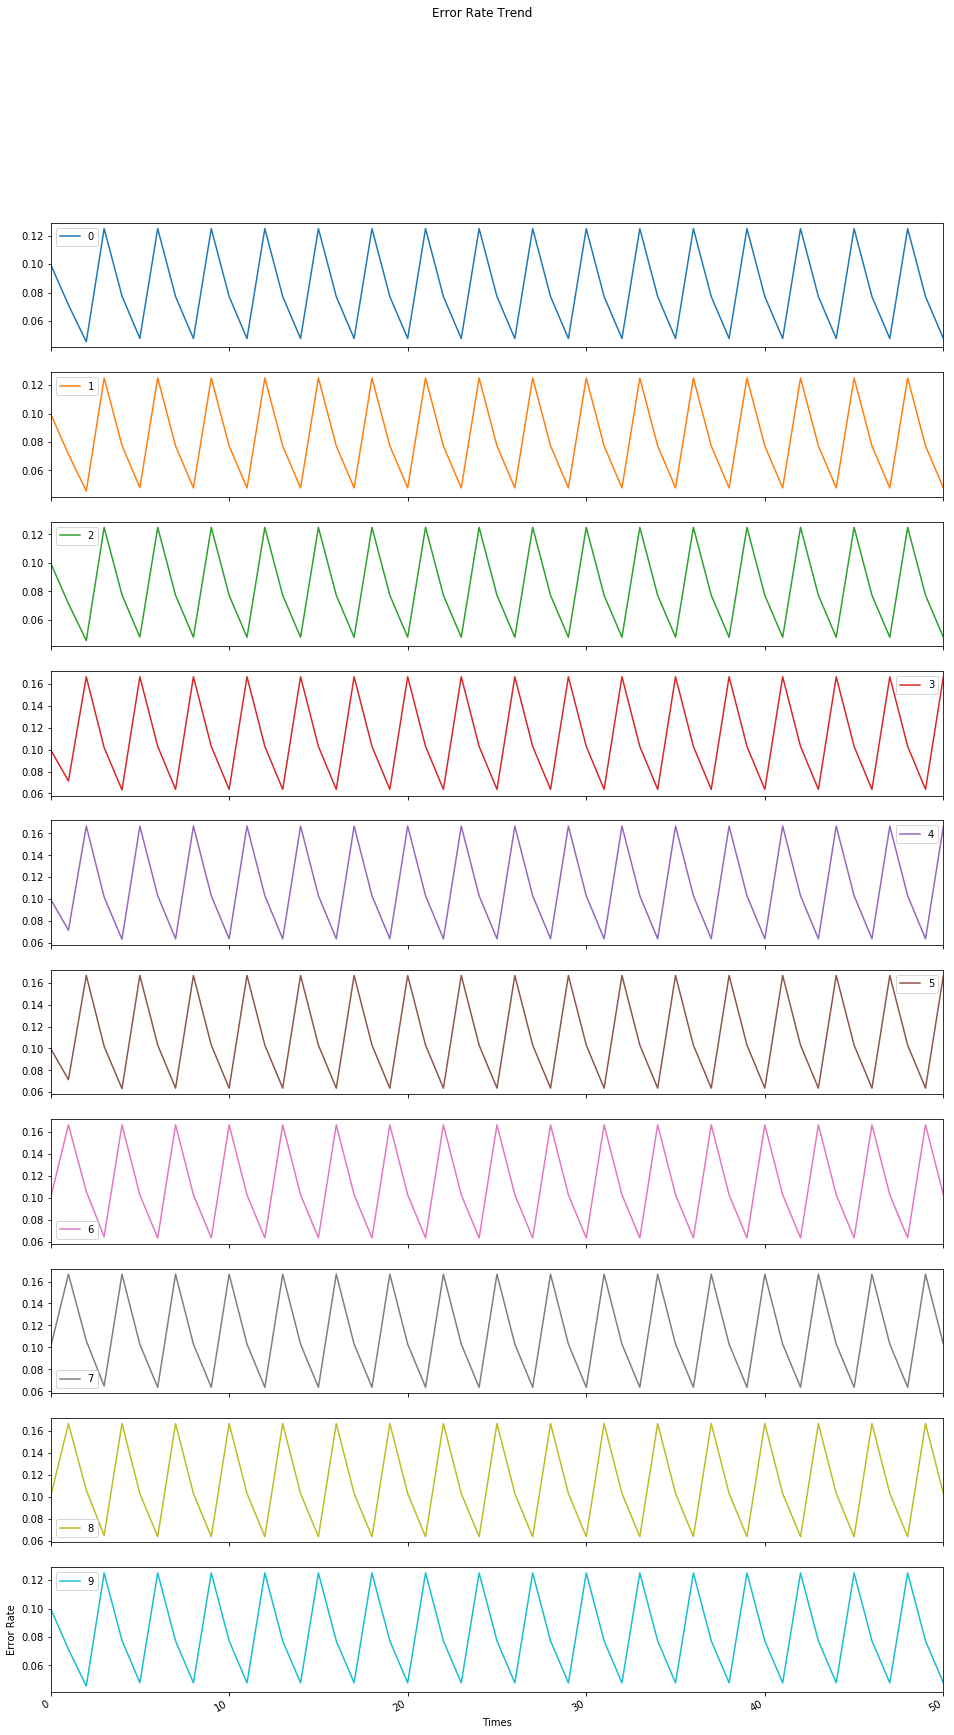

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
df.plot(subplots=True,figsize=(16,30), title="Error Rate Trend")
plt.xlabel("Times")
plt.ylabel("Error Rate")
plt.show()

# alpha和exp函数曲线

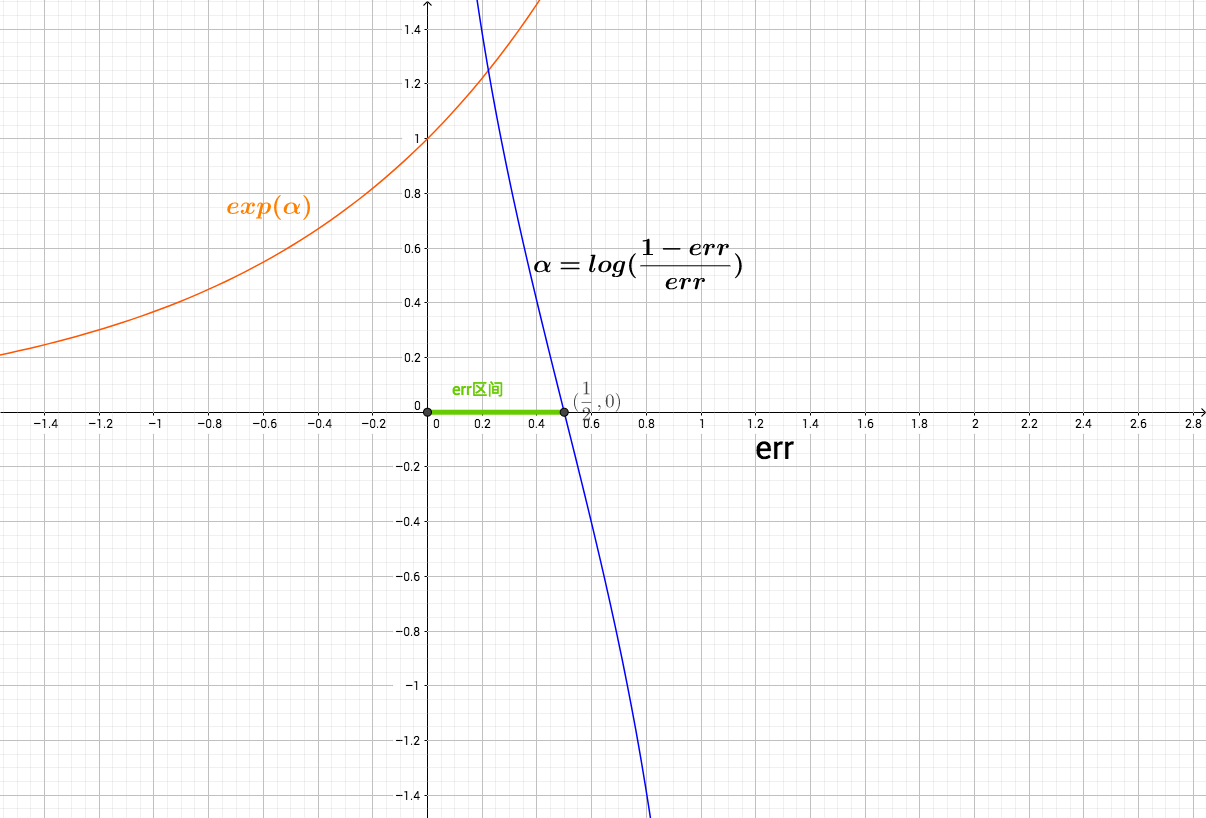

In [9]:
from PIL import Image
Image.open("./boosting.png")